# Trabalho prático 2 - Regressão

### Davi Segundo - 417153 & Diego Holanda - 411627



## Bibliotecas e módulos utilizados no trabalho

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, GroupKFold
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures

### Funções auxiliares

In [2]:
def show_metrics(results):
    r2 = results["test_r2"].mean()
    squared = results["test_neg_mean_squared_error"].mean()
    print("----------------------")
    print(f"R2_Mean: {r2*100:.2f}%")
    print(f"Mean_Squared_Error_Mean: {squared}")

### Configuração de plot dos gráficos

In [3]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

## Leitura e preparação dos dados

In [4]:
cars = pd.read_csv('./datasets/car data.csv')
cars = cars.drop(['Car_Name'], axis=1)
cars["Idade"] = 2021 - cars["Year"]
columns = ['Idade', 'Present_Price', 'Kms_Driven', 'Fuel_Type', 'Seller_Type', 'Transmission', 'Owner', 'Selling_Price']
cars = cars[columns]
cars = cars.replace({
    'Manual': 0,
    'Automatic': 1,
    'Petrol': 0,
    'Diesel': 1,
    'CNG': 2,
    'Individual': 1,
    'Dealer': 0,
})
cars

,Idade,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Selling_Price
0,7,5.59,27000,0,0,0,0,3.35
1,8,9.54,43000,1,0,0,0,4.75
2,4,9.85,6900,0,0,0,0,7.25
3,10,4.15,5200,0,0,0,0,2.85
4,7,6.87,42450,1,0,0,0,4.60
...,...,...,...,...,...,...,...,...
296,5,11.60,33988,1,0,0,0,9.50
297,6,5.90,60000,0,0,0,0,4.00
298,12,11.00,87934,0,0,0,0,3.35
299,4,12.50,9000,1,0,0,0,11.50


## Análise dos atributos do Dataset

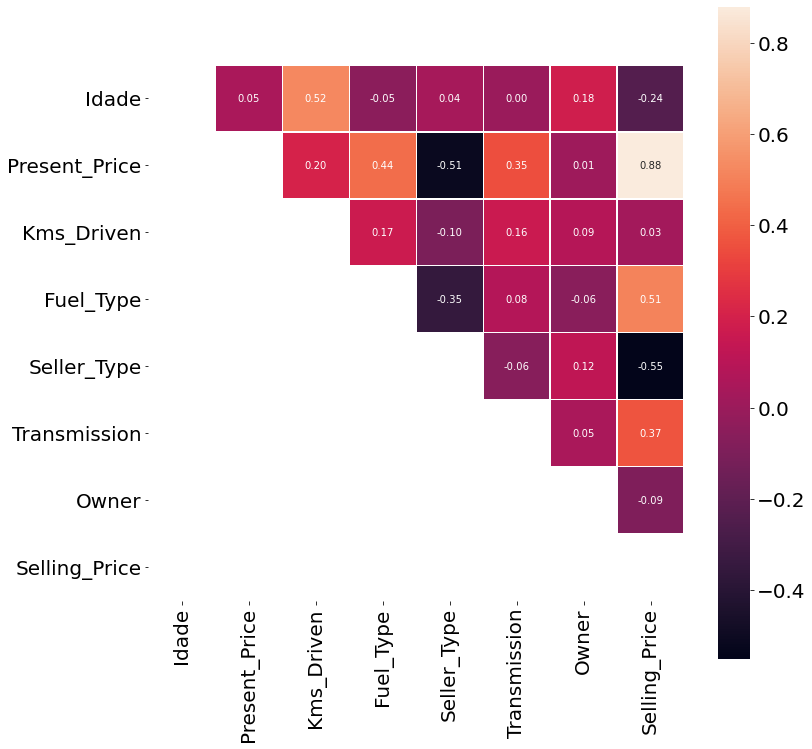

In [5]:
plt.figure(figsize=(12,12))
mask = np.tril(np.ones_like(cars.corr(), dtype=np.bool))
sns.heatmap(cars.corr(), annot=True, fmt='.2f', linewidths='0.5', square=True, mask=mask);

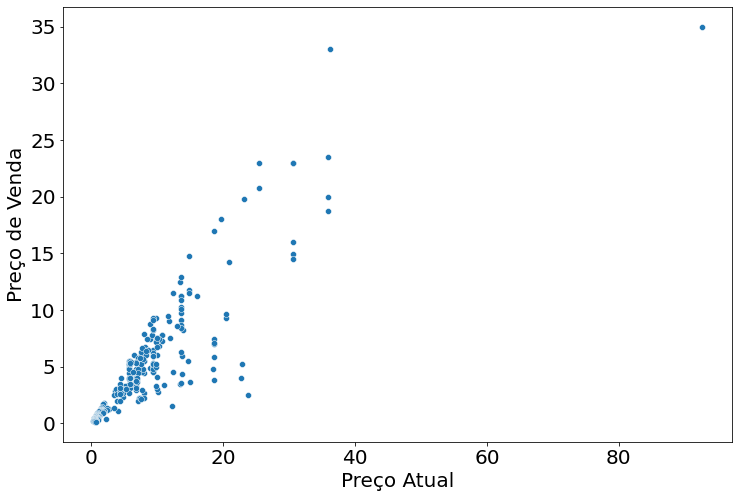

In [6]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=cars.Present_Price, y=cars.Selling_Price)
plt.ylabel('Preço de Venda', size=20)
plt.xlabel('Preço Atual', size=20);

## Separação do conjunto de treino e teste

In [7]:
np.random.seed(888)
train_set, test_set = train_test_split(cars, test_size=.2)

x_train, y_train = train_set.iloc[:, :-1], train_set.Selling_Price
x_test, y_test = test_set.iloc[:, :-1], test_set.Selling_Price

## Paramêtros de otimização do GridSearch

In [17]:
linear_parameters = {
    'model__fit_intercept' : [True, False],
}

tree_parameters = {
    'model__criterion' : ['mse', 'friedman_mse', 'mae', 'poisson'],
    'model__max_depth' : [2,3,4,5,8,10,12,15,20]
}

svr_parameters = {
    'model__kernel' : ['linear', 'poly', 'bf', 'sigmoid', 'precomputed'],
    'model__degree' : [1,2,3,4,5,8,10]
}

## Regressão Linear

In [9]:
model = LinearRegression()

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', model)
])

parameters = linear_parameters

grid = GridSearchCV(pipe, parameters)
grid.fit(x_train, y_train);
best_model_linear = grid.best_estimator_
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__fit_intercept,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004591,0.001019,0.002589,0.000494,True,{'model__fit_intercept': True},0.828924,0.867335,0.824327,0.835552,0.777656,0.826759,0.028794,1
1,0.005784,0.001163,0.002593,0.000488,False,{'model__fit_intercept': False},0.443345,0.117394,0.193585,-1.754375,-0.972580,-0.394526,0.835859,2


In [10]:
np.random.seed(42)

best_model_linear.fit(x_train, y_train)
cv = GroupKFold(n_splits=5)
results = cross_validate(best_model_linear, 
                         x_test, 
                         y_test, 
                         cv=cv, 
                         scoring=('r2', 'neg_mean_squared_error'), groups=x_test.Idade)

show_metrics(results)

----------------------
R2_Mean: 73.44%
Mean_Squared_Error_Mean: -3.259712908723486


## Árvore de Regressão

In [11]:
model = DecisionTreeRegressor()

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', model)
])

parameters = tree_parameters

grid = GridSearchCV(pipe, parameters)
grid.fit(x_train, y_train);
best_model_tree = grid.best_estimator_
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by="rank_test_score")

C:\Users\Cliente\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Cliente\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Cliente\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Cliente\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\Cliente\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 336, in fit
    criterion = CRITERIA_REG[self.criterion](self.n_outputs_,
KeyError: 'poisson'

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Cliente\anaconda3\lib\site-packages\sklearn\mode

C:\Users\Cliente\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Cliente\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Cliente\anaconda3\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Cliente\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\Cliente\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 336, in fit
    criterion = CRITERIA_REG[self.criterion](self.n_outputs_,
KeyError: 'poisson'

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Cliente\anaconda3\lib\site-packages\sklearn\mode

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__criterion,param_model__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
16,0.004593,0.000795,0.001791,3.975258e-04,friedman_mse,15,"{'model__criterion': 'friedman_mse', 'model__m...",0.974168,0.933410,0.879378,0.929212,0.954685,0.934171,0.031774,1
25,0.006789,0.000751,0.001783,7.423279e-04,mae,15,"{'model__criterion': 'mae', 'model__max_depth'...",0.958465,0.957139,0.913383,0.906937,0.913095,0.929804,0.022980,2
15,0.004587,0.000487,0.001798,7.461801e-04,friedman_mse,12,"{'model__criterion': 'friedman_mse', 'model__m...",0.968888,0.920990,0.884410,0.928307,0.945839,0.929687,0.028018,3
23,0.006787,0.000739,0.001795,7.471195e-04,mae,10,"{'model__criterion': 'mae', 'model__max_depth'...",0.967988,0.943074,0.910483,0.901270,0.904868,0.925537,0.025894,4
24,0.007386,0.001203,0.001187,4.023527e-04,mae,12,"{'model__criterion': 'mae', 'model__max_depth'...",0.959627,0.962409,0.873879,0.898167,0.910251,0.920867,0.034825,5
22,0.006734,0.000798,0.001995,1.664865e-05,mae,8,"{'model__criterion': 'mae', 'model__max_depth'...",0.965871,0.949768,0.889768,0.875300,0.913073,0.918756,0.034475,6
17,0.004391,0.000488,0.001584,4.923119e-04,friedman_mse,20,"{'model__criterion': 'friedman_mse', 'model__m...",0.970793,0.925325,0.848907,0.924324,0.923892,0.918648,0.039210,7
14,0.003990,0.000621,0.001989,1.078432e-05,friedman_mse,10,"{'model__criterion': 'friedman_mse', 'model__m...",0.976267,0.938235,0.736986,0.928795,0.938105,0.903678,0.084930,8
21,0.005983,0.000901,0.001790,7.272592e-04,mae,5,"{'model__criterion': 'mae', 'model__max_depth'...",0.932649,0.956150,0.884338,0.878877,0.849867,0.900376,0.038530,9
6,0.004583,0.000499,0.001999,8.989504e-04,mse,12,"{'model__criterion': 'mse', 'model__max_depth'...",0.784234,0.929673,0.876342,0.938136,0.940205,0.893718,0.059524,10


In [14]:
np.random.seed(888)

best_model_tree.fit(x_train, y_train)
cv = GroupKFold(n_splits=5)
results = cross_validate(best_model_tree, 
                         x_test, 
                         y_test, 
                         cv=cv, 
                         scoring=('r2', 'neg_mean_squared_error'), groups=x_test.Idade)

show_metrics(results)

----------------------
R2_Mean: 75.62%
Mean_Squared_Error_Mean: -2.8163075641025643


## Comparação entre as predições dos dois Modelos

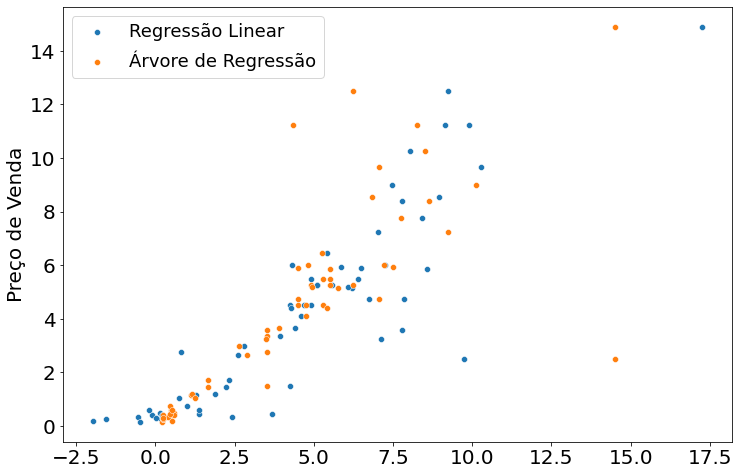

In [29]:
pred_linear = (best_model_linear.predict(x_test).reshape(61))
pred_tree = (best_model_tree.predict(x_test).reshape(61))

plt.figure(figsize=(12,8))
sns.scatterplot(x=pred_linear, y=y_test, label='Regressão Linear')
sns.scatterplot(x=pred_tree, y=y_test, label='Árvore de Regressão')
plt.legend(prop={'size' : 18})
plt.ylabel('Preço de Venda', size=20);